# Bayesian Logistic Regression with rstanarm 

Preprocessing of Pima Indian dataset is from a [noteebok][4] by [Lao Zhang][5]

The introduction to Bayesian logistic regression and **rstanarm** is from a 
[CRAN vignette][1] by Jonah Gabry and Ben Goodrich.

[CRAN vignette][1] was ported by [Aki Vehtari][2]. *Instead of wells data in CRAN vignette, Pima Indians data is used.* The end of this notebook differs significantly from the CRAN vignette.

You can read more about how to use **rstanarm** in [several vignettes at CRAN][3].

  [1]: https://cran.r-project.org/web/packages/rstanarm/vignettes/binomial.html
  [2]: https://users.aalto.fi/~ave/
  [3]: https://cran.r-project.org/web/packages/rstanarm/
  [4]: https://www.kaggle.com/laozhang/d/uciml/pima-indians-diabetes-database/statistical-learning-with-r/run/445129
  [5]: https://www.kaggle.com/laozhang

---

# Introduction

This vignette explains how to estimate generalized linear models (GLMs) for 
binary (Bernoulli) and Binomial response variables using the `stan_glm`
function in the __rstanarm__ package.

The four steps of a Bayesian analysis are

1. Specify a joint distribution for the outcome(s) and all the unknowns, which
  typically takes the form of a marginal prior distribution for the unknowns
  multiplied by a likelihood for the outcome(s) conditional on the unknowns.
  This joint distribution is proportional to a posterior distribution of the
  unknowns conditional on the observed data.
2. Draw from posterior distribution using Markov Chain Monte Carlo (MCMC).
3. Evaluate how well the model fits the data and possibly revise the model.
4. Draw from the posterior predictive distribution of the outcome(s) given
  interesting values of the predictors in order to visualize how a manipulation
  of a predictor affects (a function of) the outcome(s).

Steps 3 and 4 are covered in more depth by the vignette entitled ["How to Use the
__rstanarm__ Package"](https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html). This vignette focuses on Step 1 when the likelihood is
the product of conditionally independent binomial distributions (possibly with
only one trial per observation).

[Other vignettes are also available](https://cran.r-project.org/web/packages/rstanarm/vignettes/).

# Theory

## Likelihood

For a binomial GLM the likelihood for one observation $y$ can be written as a conditionally binomial PMF

$$\binom{n}{y} \pi^{y} (1 - \pi)^{n - y}$$

where:
* $n$ is the known number of trials.
* $\pi = g^{-1}(\eta)$ is the probability of success.
* $\eta = \alpha + \mathbf{x}^\top \boldsymbol{\beta}$ is a linear predictor that is used to calculate the probability of success.

For a sample of size $N$, the likelihood of the entire sample is the product of $N$ individual likelihood contributions, which can be stated as:

$$
  \prod_{i=1}^N {
  g^{-1}\left(\eta_i\right)^{y_i} 
  \left(1 - g^{-1}\left(\eta_i\right)\right)^{n_i-y_i}}$$
  
Or the fully expanded form including the linear predictor: 
  

$$
  \prod_{i=1}^N {
  g^{-1}\left((\alpha + \mathbf{x}^\top \boldsymbol{\beta})_i\right)^{y_i} 
  \left(1 - g^{-1}\left((\alpha + \mathbf{x}^\top \boldsymbol{\beta})_i\right)\right)^{n_i-y_i}}$$
  
One could read this as:
"The total likelihood for a general binomial model is the product of the probability of success and failures for for every observation in a sample size $N$. "

Because $\pi$ is a probability, for a binomial model the _link_ function $g$ maps between the unit interval (`0,1` as necessitated to support probability $\pi$) and the set of all real numbers $\mathbb{R}$. When applied to a linear predictor $\eta$ with values in $\mathbb{R}$, the inverse link function $g^{-1}(\eta)$ therefore returns a valid probability between 0 and 1 (Using real values $\mathbb{R}$, map *back* to a unit interval for $\eta$). 

These link functions are therefore how we describe these probability distributions, and are necessary to the success of this formula. The two most common link functions used for binomial GLMs are the [logit](https://en.wikipedia.org/wiki/Logit) and [probit](https://en.wikipedia.org/wiki/Probit) functions. 

### Logit:
The logit function is the inverse of the sigmoidal "logistic" function, and maps real values ($\mathbb{R}$) to an activation range between 0 and 1. We could use any base, but the natural logarithm $e$ is typically used:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Logit.svg/350px-Logit.svg.png)

With the logit (or log-odds) link function $g(x) = \ln{\left(\frac{x}{1-x}\right)}$, the likelihood for a single observation in our model now becomes:

$$\binom{n}{y}\left(\text{logit}^{-1}(\eta)\right)^y 
\left(1 - \text{logit}^{-1}(\eta)\right)^{n-y} = 
\binom{n}{y} \left(\frac{e^{\eta}}{1 + e^{\eta}}\right)^{y}
\left(\frac{1}{1 + e^{\eta}}\right)^{n - y}$$

### Probit: 
The probit function is the quantile function associated with the standard normal distribution, which is commonly denoted as N(0,1). 

One could think of it like a function to map via the 'z-table' method; a means to convert a real value into an probability on a standard normal curve using the inverse of the cumulative distribution function of a standard normal distribution"


$$\Phi^{-1} (X = 1.96)=0.025$$
$$\Phi^{-1} (X = 1.96)=0.975$$

Mathematically, it is the inverse of the cumulative distribution function of the standard normal distribution, which is denoted as $\Phi (z)$, so the probit is denoted as ${\Phi ^{-1}(p)}$: 

When we use the probit as the link function $g(x) = \Phi^{-1}(x)$, we yield the new likelihood likelihood:

$$\binom{n}{y} \left(\Phi(\eta)\right)^{y}
\left(1 - \Phi(\eta)\right)^{n - y},$$

where $\Phi$ is the CDF of the standard normal distribution. 

## Difference

The differences between the logit and probit functions are minor and -- if, as __rstanarm__ does by default, the probit is scaled so its slope at the origin matches the logit's -- the two link functions should yield similar results. (This is also intuitive, since the sigmoidal logistic function is the typical shape of a CDF, which is what the probit inverts to calculate) 

With `stan_glm`, binomial models with a logit link function can typically be fit **slightly faster** than the identical model with a probit link because of how the two models are  implemented in Stan. Unless the user has a *specific reason* to prefer the probit link, **we recommend the logit simply because it will be slightly faster and more numerically stable**.

In theory, there are infinitely many possible link functions, although in practice only a few are typically used. 

Other common choices are the:
* `cauchit` link function: Uses the cauchy distribution. 
* `cloglog` link function: The complementary log-log model. 

And others [explored here](http://www.stats.uwo.ca/faculty/bellhouse/Links.pdf), which can also be used with `stan_glm` (every link  function compatible with`glm` will work with `stan_glm`).

## Bayesian General Linear Model

A full Bayesian analysis using the General Linear Model (GLM): $\eta = \alpha + \mathbf{x}^\top \boldsymbol{\beta}$ requires us to specify the prior distributions $f(\alpha)$ and $f(\boldsymbol{\beta})$  for the intercept and vector of regression coefficients.

These can generally be thought of as the 'distributions' of these variables, which we will use to inform the posterior.  

When using `stan_glm`, these distributions can be set using the `prior_intercept` and `prior` arguments. The `stan_glm` function supports a variety of prior distributions, which are explained in the __rstanarm__
documentation (`help(priors, package = 'rstanarm')`):

In [17]:
help(priors, package = 'rstanarm')

priors {rstanarm},R Documentation
location,"Prior location. For normal and student_t (provided that df > 1) this is the prior mean. For cauchy (which is equivalent to student_t with df=1), the mean does not exist and location is the prior median. The default value is 0, except for R2 which has no default value for location. For R2, location pertains to the prior location of the R^2 under a Beta distribution, but the interpretation of the location parameter depends on the specified value of the what argument (see the ""R2 family"" section in Details)."
scale,Prior scale. The default depends on the family (see Details).
"df, df1, df2","Prior degrees of freedom. The default is 1 for student_t, in which case it is equivalent to cauchy. For the hierarchical shrinkage priors (hs and hs_plus) the degrees of freedom parameter(s) default to 3."
regularization,"Exponent for an LKJ prior on the correlation matrix in the decov prior. The default is 1, implying a joint uniform prior."
concentration,"Concentration parameter for a symmetric Dirichlet distribution. The default is 1, implying a joint uniform prior."
shape,Shape parameter for a gamma prior on the scale parameter in the decov prior. If shape and scale are both 1 (the default) then the gamma prior simplifies to the unit-exponential distribution.
what,"A character string among 'mode' (the default), 'mean', 'median', or 'log' indicating how the location parameter is interpreted in the LKJ case. If 'log', then location is interpreted as the expected logarithm of the R^2 under a Beta distribution. Otherwise, location is interpreted as the what of the R^2 under a Beta distribution. If the number of predictors is less than or equal to two, the mode of this Beta distribution does not exist and an error will prompt the user to specify another choice for what."
prior_scale_for_dispersion,"Prior scale for the standard error of the regression in Gaussian models, which is given a half-Cauchy prior truncated at zero."
min_prior_scale,Minimum prior scale for the intercept and coefficients.
scaled,"A logical scalar, defaulting to TRUE. If TRUE then the scales of the priors on the regression coefficients may be additionally modified internally by rstanarm as follows. First, if response is Gaussian, the prior scales also multiplied by 2*sd(y). Additionally, if the QR argument to the model fitting function (e.g. stan_glm) is FALSE then: for a predictor with only one value nothing is changed; for a predictor x with exactly two unique values, we take the user-specified (or default) scale(s) for the selected priors and divide by the range of x; for a predictor x with more than two unique values, we divide the prior scale(s) by 2*sd(x)."


For example, suppose we have $K$ predictors and believe --- prior to seeing 
the data --- that $\alpha, \beta_1, \dots, \beta_K$ (intercepts & all regression coeffecients) are as **likely to be positive
as they are to be negative**, but are **highly unlikely to be far from zero**. 

These beliefs can be represented by **normal distributions with mean zero and a small
scale (standard deviation)**. 

To give $\alpha$ and each of the $\beta$s for this prior (with a scale of 1, say), in the call to `stan_glm` we would include the arguments `prior_intercept = normal(0,1)` and `prior = normal(0,1)`.

In [18]:
# Toy function to illustrate the idea; don't run it, won't work
posterior <- stan_glm(outcome ~ ., data = dataset,
                 family = binomial(link = "logit"), 
                 prior = normal(0,1), prior_intercept = normal(0,1)
                 )

ERROR: Error in is.data.frame(data): object 'dataset' not found


If, on the other hand, we have less a priori confidence that the parameters will
be close to zero then we could use a larger scale for the normal distribution 
and/or a distribution with heavier tails than the normal like the Student t 
distribution.

In [19]:
# New toy posterior, with t_distributions instead
posterior <- stan_glm(outcome ~ ., data = dataset,
                 family = binomial(link = "logit"), 
                 prior = student_t(), prior_intercept = student_t()
                 )

ERROR: Error in is.data.frame(data): object 'dataset' not found


[__Step 1__ in the "How to Use the __rstanarm__ Package" vignette discusses one such example.](https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html)

Therefore, **for the Bayes GLM, we define the prior and prior intercept via the distributions we expect these variables to take**, and `stan_glm` **allows us to switch between distributions easily**. In general, normal distributions may suffice, but more complex distributions may be far more appropriate for more applications, and warrant investigation.

## Posterior

With independent prior distributions, the joint posterior distribution for $\alpha$ and $\boldsymbol{\beta}$ is proportional to the product of the **priors** and the $N$ **likelihood contributions**:


$$f\left(\alpha,\boldsymbol{\beta} | \mathbf{y},\mathbf{X}\right) \propto
  f\left(\alpha\right) \times \prod_{k=1}^K f\left(\beta_k\right) \times
  \prod_{i=1}^N {
  g^{-1}\left(\eta_i\right)^{y_i} 
  \left(1 - g^{-1}\left(\eta_i\right)\right)^{n_i-y_i}}$$

This is posterior distribution that `stan_glm` will draw from when using MCMC.
  

## Logistic Regression Example

When the logit link function is used the model is often referred to as a  logistic regression model (the inverse logit function is the CDF of the standard logistic distribution). As an example, here we will show how to carry out a 
analysis for Pima Indians data set similar to analysis from Chapter 5.4 of [Gelman and Hill (2007)](http://www.stat.columbia.edu/~gelman/arm/)  using `stan_glm`.

# Application

## Dataset

Before we use the model, we must first prepare the dataset.

In [4]:
# file preview shows a header row
diabetes <- read.csv("data/diabetes.csv", header = TRUE)

# first look at the data set using summary() and str() to understand what type of data are you working
# with
summary(diabetes)
str(diabetes)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    Insulin           BMI        DiabetesPedigreeFunction      Age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780           Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437           1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725           Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719           Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262           3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
    Outcome  

'data.frame':	768 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 0 1 1 ...


## Preparation

**Factors** allow us to treat a given numeric and string vector as a more discrete object via 'levels', which becomes helpful when associating variables with changes in levels later. Not the change in the `data.frame` summary below:

In [5]:
diabetes$Outcome <- factor(diabetes$Outcome)

In [6]:
summary(diabetes)
str(diabetes)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    Insulin           BMI        DiabetesPedigreeFunction      Age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780           Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437           1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725           Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719           Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262           3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outcome
 0:5

'data.frame':	768 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 2 1 2 1 2 1 2 1 2 2 ...


Rows with zeroes will throw our model later, so lets **get rid of any rows with any 0s**. This cuts our dataset down significantly, but will save us some issues later.

In [7]:
# removing those observation rows with 0 in any of the variables
for (i in 2:6) {
# For vector 2 to 6
      diabetes <- diabetes[-which(diabetes[, i] == 0), ]
    # Remove every row where the column value is 0
}

In [8]:
str(diabetes)
summary(diabetes)
# From 768 to 392 obs. 

'data.frame':	392 obs. of  9 variables:
 $ Pregnancies             : int  1 0 3 2 1 5 0 1 1 3 ...
 $ Glucose                 : int  89 137 78 197 189 166 118 103 115 126 ...
 $ BloodPressure           : int  66 40 50 70 60 72 84 30 70 88 ...
 $ SkinThickness           : int  23 35 32 45 23 19 47 38 30 41 ...
 $ Insulin                 : int  94 168 88 543 846 175 230 83 96 235 ...
 $ BMI                     : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ DiabetesPedigreeFunction: num  0.167 2.288 0.248 0.158 0.398 ...
 $ Age                     : int  21 33 26 53 59 51 31 33 32 27 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 1 2 1 ...


  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outco

Scaling helps us **normalize** the data. There is amuch more helpful exploration of this phenomenon [over here](http://gastonsanchez.com/how-to/2014/01/15/Center-data-in-R/), but the short version is `scale()` quickly standardizes the data with mean zero & unit (1) variance.

In [9]:
# scale the covariates for easier comparison of coefficient posteriors
for (i in 1:8) {
      diabetes[i] <- scale(diabetes[i])
}
# Also seems to append the old name of the variable into it, but they still have the same references

In [10]:
summary(diabetes)
# Not how the min, max, and other values now reflet much smaller numbers that are generally standardized 
# The string names seem different, but diabetes$pregnancies is still totally valid. Not sure why the strings have
# changed

 Pregnancies.Pregnancies   Glucose.Glucose    BloodPressure.BloodPressure
 Min.   :-1.027899       Min.   :-2.1589717   Min.   :-3.734229          
 1st Qu.:-0.716511       1st Qu.:-0.7656174   1st Qu.:-0.693278          
 Median :-0.405123       Median :-0.1175457   Median :-0.053078          
 Mean   : 0.000000       Mean   : 0.0000000   Mean   : 0.000000          
 3rd Qu.: 0.529042       3rd Qu.: 0.6601404   3rd Qu.: 0.587122          
 Max.   : 4.265702       Max.   : 2.4423377   Max.   : 3.147923          
 SkinThickness.SkinThickness   Insulin.Insulin         BMI.BMI      
 Min.   :-2.105793           Min.   :-1.195339   Min.   :-2.118234  
 1st Qu.:-0.774542           1st Qu.:-0.667326   1st Qu.:-0.666826  
 Median :-0.013827           Median :-0.257116   Median : 0.016190  
 Mean   : 0.000000           Mean   : 0.000000   Mean   : 0.000000  
 3rd Qu.: 0.746888           3rd Qu.: 0.285623   3rd Qu.: 0.571140  
 Max.   : 3.219211           Max.   : 5.805571   Max.   : 4.839986  

Lets **rename** The `DiabetesPedigreeFunction.DiabetesPedigreeFunction` to something a little easier, and make all of our names lowercase:

In [11]:
# modify the data column names slightly for easier typing
names(diabetes)[7] <- "dpf"
names(diabetes) <- tolower(names(diabetes))

In [12]:
summary(diabetes)

 pregnancies.Pregnancies   glucose.Glucose    bloodpressure.BloodPressure
 Min.   :-1.027899       Min.   :-2.1589717   Min.   :-3.734229          
 1st Qu.:-0.716511       1st Qu.:-0.7656174   1st Qu.:-0.693278          
 Median :-0.405123       Median :-0.1175457   Median :-0.053078          
 Mean   : 0.000000       Mean   : 0.0000000   Mean   : 0.000000          
 3rd Qu.: 0.529042       3rd Qu.: 0.6601404   3rd Qu.: 0.587122          
 Max.   : 4.265702       Max.   : 2.4423377   Max.   : 3.147923          
 skinthickness.SkinThickness   insulin.Insulin         bmi.BMI      
 Min.   :-2.105793           Min.   :-1.195339   Min.   :-2.118234  
 1st Qu.:-0.774542           1st Qu.:-0.667326   1st Qu.:-0.666826  
 Median :-0.013827           Median :-0.257116   Median : 0.016190  
 Mean   : 0.000000           Mean   : 0.000000   Mean   : 0.000000  
 3rd Qu.: 0.746888           3rd Qu.: 0.285623   3rd Qu.: 0.571140  
 Max.   : 3.219211           Max.   : 5.805571   Max.   : 4.839986  

## Setup

First step is deciding our **input** variables for the model.

R has an object called a `model.matrix` which is conveniently designed to hold all these model variables. It takes regression notation, so our task of regressing `outcome` against every other variable is noted: `outcome ~ . -1`. 

That last bit is nomenclature, we use `.` to denote **every available column**, and the `-1` to state that we don't want the **intercept vector** to count as an input variable; it will be generated as part of the `glm`. Here's what that looks like:

In [13]:
model.matrix(outcome ~ . - 1, data = diabetes)

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,dpf,age
4,-0.716510831731856,-1.08965328588737,-0.373177907818495,-0.584362921139607,-0.522174689475281,-0.709514269939694,-1.03055930843226,-0.967063231434636
5,-1.02789913110978,0.465718905529468,-2.45382847482402,0.556709383152926,0.100502421118279,1.42490909404547,5.10858224726345,0.209317797959863
7,-0.0937342329760078,-1.4460927464204,-1.65357825674497,0.271441307079793,-0.57266202276665,-0.296859086235896,-0.796108357931857,-0.476904469186928
9,-0.405122532353932,2.40993414480051,-0.0530778205868761,1.50760297006337,3.25596075182889,-0.368006531702068,-1.05660941404341,2.1699528469507
14,-0.716510831731856,2.15070544623104,-0.853328038665924,-0.584362921139607,5.80557108304306,-0.424924488075005,-0.361939931079261,2.75814336164795
15,0.529042365779841,1.40542293784381,0.106972223028934,-0.964720355903785,0.159404309958211,-1.03679251908409,0.18511228675501,1.97388934205161
17,-1.02789913110978,-0.149949253573031,1.06727248472379,1.69778168744546,0.6222048651291,1.8091052995628,0.080911864310387,0.01325429306078
19,-0.716510831731856,-0.636003063390792,-3.25407869290307,0.84197745922606,-0.614734800509459,1.45336807223194,-0.984248009567981,0.209317797959863
20,-0.716510831731856,-0.247160015536583,-0.0530778205868761,0.0812625896977039,-0.505345578378157,0.215402521120544,0.0172338283720062,0.111286045510322
21,-0.0937342329760078,0.109279444996442,1.38737257195541,1.12724553529919,0.664277642871908,0.884188508502561,0.523763659700034,-0.378872716737387


Lets assign that alongside our **output** variable, in this case `outcome`. 

In [14]:
# preparing the inputs
x <- model.matrix(outcome ~ . - 1, data = diabetes)
y <- diabetes$outcome

## Model

We'll be using the `rstanarm` package, which builds off the venerable [Stan](http://mc-stan.org/) C++ package. Let's install it:

In [15]:
#install.packages('rstanarm', repos='http://cran.us.r-project.org', type='source')
#devtools::install_github("stan-dev/rstanarm", local = FALSE)

# For some reason, the rstanarm package has compilation errors when installed via Jupyter
# So I installed it via Terminal instead

In [16]:
# Load the package
library(rstanarm)

Loading required package: Rcpp
Warning message:
: package ‘Rcpp’ was built under R version 3.2.5Warning message:
: replacing previous import by ‘stats::cov2cor’ when loading ‘rstanarm’rstanarm (Version 2.13.1, packaged: 2016-11-20 16:59:31 UTC)
- Do not expect the default priors to remain the same in future rstanarm versions.
Thus, R scripts should specify priors explicitly, even if they are just the defaults.
- For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores())


A Bayesian version of logistic regression model can be estimated using the `stan_glm` function inside the package. The `_glm` bit stands for `generalized linear models`: 

In [17]:
?stan_glm

stan_glm {rstanarm},R Documentation
"formula, data, subset",Same as glm.
family,"Same as glm, except negative binomial GLMs are also possible using the neg_binomial_2 family object."
"na.action, contrasts","Same as glm, but rarely specified."
"model, offset, weights",Same as glm.
"x, y","In stan_glm, stan_glm.nb, logical scalars indicating whether to return the design matrix and response vector. In stan_glm.fit, a design matrix and response vector."
...,"Further arguments passed to the function in the rstan package (sampling, vb, or optimizing), corresponding to the estimation method named by algorithm. For example, if algorithm is ""sampling"" it is possibly to specify iter, chains, cores, refresh, etc."
prior,"The prior distribution for the regression coefficients. prior can be a call to normal, student_t, cauchy, hs or hs_plus. See priors for details. To omit a prior —i.e., to use a flat (improper) uniform prior— prior can be set to NULL, although this is rarely a good idea. (Note: unless QR=TRUE, if the scaled argument to prior_options is left at its default and recommended value of TRUE, then the scale(s) of prior may be modified internally based on the scales of the predictors, as in the arm package. See priors for details on the rescaling and prior_summary for a summary of the priors used for a particular model.)"
prior_intercept,"The prior distribution for the intercept. prior_intercept can be a call to normal, student_t or cauchy. See priors for details. To to omit a prior —i.e., to use a flat (improper) uniform prior— set prior_intercept to NULL. (Note: if a dense representation of the design matrix is utilized —i.e., if the sparse argument is left at its default value of FALSE— then the prior distribution for the intercept is set so it applies to the value when all predictors are centered.)"
prior_ops,Additional options related to prior distributions. Can be NULL to omit a prior on the dispersion and see prior_options otherwise.
prior_PD,A logical scalar (defaulting to FALSE) indicating whether to draw from the prior predictive distribution instead of conditioning on the outcome.


In [18]:
summary(x)

  pregnancies         glucose        bloodpressure      skinthickness     
 Min.   :-1.0279   Min.   :-2.1590   Min.   :-3.73423   Min.   :-2.10579  
 1st Qu.:-0.7165   1st Qu.:-0.7656   1st Qu.:-0.69328   1st Qu.:-0.77454  
 Median :-0.4051   Median :-0.1175   Median :-0.05308   Median :-0.01383  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.5290   3rd Qu.: 0.6601   3rd Qu.: 0.58712   3rd Qu.: 0.74689  
 Max.   : 4.2657   Max.   : 2.4423   Max.   : 3.14792   Max.   : 3.21921  
    insulin             bmi                dpf               age         
 Min.   :-1.1953   Min.   :-2.11823   Min.   :-1.2679   Min.   :-0.9671  
 1st Qu.:-0.6673   1st Qu.:-0.66683   1st Qu.:-0.7332   1st Qu.:-0.7710  
 Median :-0.2571   Median : 0.01619   Median :-0.2129   Median :-0.3789  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.2856   3rd Qu.: 0.57114   3rd Qu.: 0.4746   3rd Qu.: 0.5034  
 Max.   : 5.8056   Max.   : 4.8

Here we'll use a **Student t-prior** with *7 degrees of freedom* from the 8 input columns, a location (mean) of 0 after normalization, and a default scale of 2.5, which, as discussed above, is a 
**reasonable default prior distribution when coefficients should be close to zero but have some chance of being large**. 

The `formula`, `data` and `family` arguments to `stan_glm` are specified in exactly the same way as for `glm`. We've also added the `seed` (for reproducibility of the random elements). 

You can read about other possible arguments in the
`stan_glm` documentation (`help(stan_glm, package = 'rstanarm')`).

In [19]:
t_prior <- student_t(df = 7)
# There are 8 columns in the input matrix

post1 <- stan_glm(outcome ~ ., data = diabetes,
                 family = binomial(link = "logit"), 
                 prior = t_prior, prior_intercept = t_prior,
                 seed = 1)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)
 Elapsed Time: 1.01587 seconds (Warm-up)
               1.03251 seconds (Sampling)
               2.04838 seconds (Total)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 [ 

**stan_glm** returns the posterior distribution for the parameters describing the uncertainty related to unknown parameter values:

ci_level: 0.95 (95% intervals)
outer_level: 1 (100% intervals)


ERROR: Error in file(con, "rb"): cannot open the connection


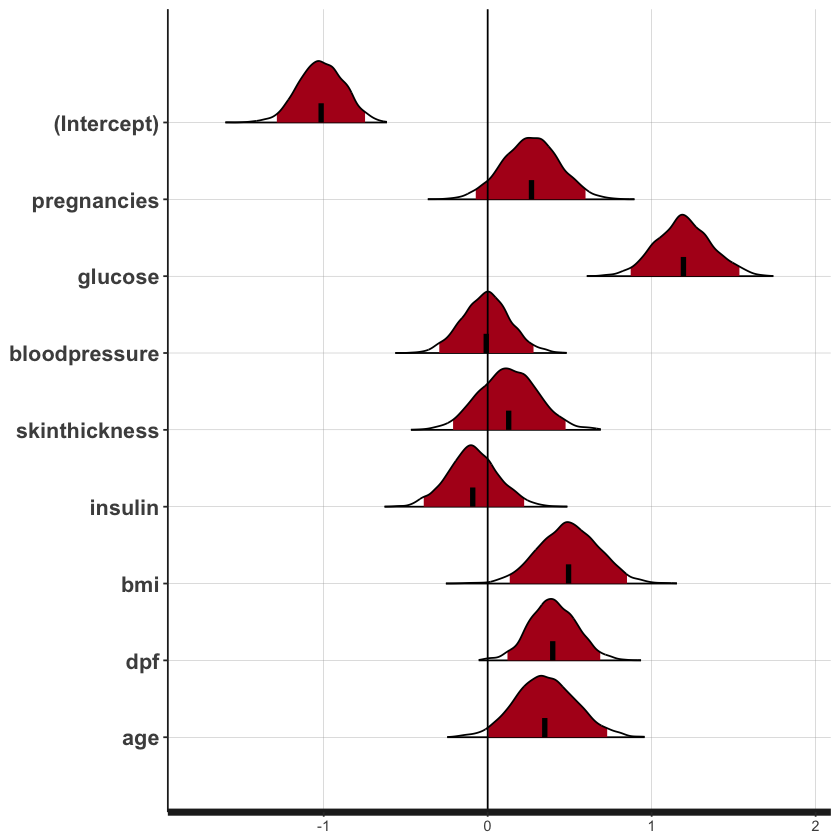

In [25]:
# Grab a plotting library (ggplot2) 
library(ggplot2)

# Get rstan again, because we need a special plot
library(rstan)

# Plot the posterior (need_stanplot from rstan, regular ggplot2 doesn't have this function)
pplot<- stan_plot(post1, ci_level = 0.95, outer_level = 1, show_density = TRUE)

# Add a 0 line for reference
pplot+ geom_vline(xintercept = 0)

What we have up here is the **posterrior** distribution of parameters, with the uncertainty estimates as described by their medians. 

A coeffecient that **we believe are very influential** on the binary `diabetes$outcome` appears to be `glucose`, `pregnancies`, and, to a lesser extent possibly `bmi`, `dpf`, and `age`.

We can extract corresponding posterior median estimates using `coef` function and  to get a sense for the uncertainty in our estimates we can use the `posterior_interval` function to get Bayesian uncertainty intervals. 

The uncertainty intervals are computed by finding the relevant quantiles of the draws from the posterior distribution. For example, to compute median and 90% intervals we use:

In [38]:
round(coef(post1), 2)
round(posterior_interval(post1, prob = 0.95), 2)

(Intercept)   pregnancies       glucose bloodpressure skinthickness 
        -1.02          0.27          1.19         -0.01          0.13 
      insulin           bmi           dpf           age 
        -0.09          0.49          0.40          0.35

,2.5%,97.5%
(Intercept),-1.29,-0.75
pregnancies,-0.07,0.60
glucose,0.87,1.54
bloodpressure,-0.30,0.28
skinthickness,-0.21,0.47
insulin,-0.39,0.22
bmi,0.13,0.85
dpf,0.12,0.69
age,0.00,0.73


For more on `posterior_interval` and interpreting the parameter estimates from a Bayesian
model see Step 2 in the ["How to Use the __rstanarm__ Package"][1] vignette.

[1]: https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html

__rstanarm__ supports __loo__ package which implements fast [Pareto smoothed leave-one-out cross-validation (PSIS-LOO)][1] to compute expected log predictive density (elpd):

[1]: https://arxiv.org/abs/1507.04544

In [39]:
library(loo)
(loo1 <- loo(post1))

Warning message:
: package ‘loo’ was built under R version 3.2.4This is loo version 0.1.6


Computed from 4000 by 392 log-likelihood matrix

         Estimate   SE
elpd_loo   -181.6 11.9
p_loo        10.2  1.3
looic       363.2 23.7

All Pareto k estimates OK (k < 0.5)

Above we see that PSIS-LOO result is reliable as all Pareto k estimates are small (k< 0.5)

For more easily interpretable predictive performance measures, we next compute posterior predictive probabilities and use them to compute classification errors, ROC and AUC (some of these will be later included in loo package).

In [42]:
# Predicted probabilities
linpred <- posterior_linpred(post1)
preds <- posterior_linpred(post1, transform=TRUE)
pred <- colMeans(preds)
pr <- as.integer(pred >= 0.5)

In [43]:
# Plot performance measures
library(caret)

# confusion matrix
confusionMatrix(pr, y)[2:3]
# posterior classification accuracy
round(mean(xor(pr,as.integer(y))),3)
# posterior balanced classification accuracy
round((mean(xor(pr[y==0]>0.5,as.integer(y[y==0])))+mean(xor(pr[y==1]>0.5,as.integer(y[y==1]))))/2,3)

Warning message:
: package ‘caret’ was built under R version 3.2.5

ERROR: Error: package or namespace load failed for ‘caret’


ERROR: Error in eval(expr, envir, enclos): could not find function "confusionMatrix"


[1] 0.737

[1] 0.66

The predictive performance above is overoptimistic. To better estimate the predictive performance for new not yet seen data we next use leave-one-out cross-validation:

In [ ]:
# PSIS-LOO weights
log_lik=log_lik(post1, parameter_name = "log_lik")
psis=psislw(-log_lik)
#plot(psis$pareto_k)
#plot(psis$lw_smooth[,1],linpred[,1])
# LOO predictive probabilities
ploo=colSums(preds*exp(psis$lw_smooth))
# LOO classification accuracy
round(mean(xor(ploo>0.5,as.integer(y))),3)
# LOO balanced classification accuracy
round((mean(xor(ploo[y==0]>0.5,as.integer(y[y==0])))+mean(xor(ploo[y==1]>0.5,as.integer(y[y==1]))))/2,2)

In this case it happens that all predicted classes are same as with posterior predictions. We can see the small difference in posterior predictive probabilities and LOO proabilities:

In [ ]:
plot(pred,ploo)

We can also sompute ROC and AUC using posterior or LOO probabilities.

In [ ]:
# compute AUCs
library(pROC)
plot.roc(y,pred,percent=TRUE,col="#1c61b6",  print.auc=TRUE)
plot.roc(y,ploo,percent=TRUE,col="#008600",  print.auc=TRUE, print.auc.y=40, add=TRUE)

legend("bottomright", legend=c("Posterior ROC", "LOO ROC"), col=c("#1c61b6", "#008600"), lwd=2)